In [1]:
"""
This notebook creates publication-quality visualizations of benchmark forecasts.
Supports both logistic and Harvey models with flexible styling options.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from datetime import timedelta, date
import arviz as az
from scipy.stats import skewnorm
import pickle

# Set elegant style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['axes.facecolor'] = '#fafafa'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.2

# Color palette - elegant and professional
BASE_COLOR = '#183f60'      # Deep blue (main curves)
ACCENT_COLOR = '#d4af37'    # Gold (highlights)
GRAY_COLOR = '#6c757d'      # Gray (reference lines)
INTERVAL_COLORS = {
    'light': '#b8cfe0',     # Light blue (95% CI)
    'medium': '#7fa8c9',    # Medium blue (50% CI)
    'prediction': '#8b7f7b' # Light brown (prediction interval)
}

# CONFIG

In [2]:
# Default fit to use (can be changed)
DEFAULT_FIT = "harvey_joint_hyperparameters_all"  # Options:
# - "logistic_independent"
# - "logistic_joint_hyperparameters_all"
# - "harvey_independent"
# - "harvey_joint_hyperparameters_all"

DEFAULT_TOP_N = 3

# Available benchmarks (update this list based on your data)
INTERNAL_BENCHMARKS = [
    "bench.task.frontiermath.frontiermath_2025_02_28_private",
    "bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private",
    "bench.task.gpqa.gpqa_diamond",
    "bench.task.hendrycks_math.hendrycks_math_lvl_5",
    "bench.task.otis_mock_aime.otis_mock_aime_24_25",
    "bench.task.swe_bench.swe_bench_verified",
]

EXTERNAL_BENCHMARKS = [
    "ARC AGI",
    "ARC AI2",
    "Adversarial NLI",
    "Aider polyglot",
    "BBH",
    "Balrog",
    "BoolQ",
    "CadEval",
    "CommonSenseQA 2",
    "Cybench",
    "DeepResearch Bench",
    "EnigmaEval",
    "Fiction.LiveBench",
    "GSM8K",
    "GSO-Bench",
    "HellaSwag",
    "LAMBADA",
    "Lech Mazur Writing",
    "LiveBench",
    "MMLU",
    "OS World (Screenshot)",
    "OSUniverse",
    "OpenBookQA",
    "PIQA",
    "ScienceQA",
    "SimpleBench",
    "Terminal Bench",
    "The Agent Company",
    "ToolComp",
    "TriviaQA",
    "VISTA",
    "VPCT",
    "VideoMME",
    "WeirdML V2",
    "WinoGrande",
]

ALL_BENCHMARKS = INTERNAL_BENCHMARKS + EXTERNAL_BENCHMARKS

# ---------------------------------------------------------
# Tier 3 – benchmarks that are clearly hard AND tightly 
# linked to loss-of-control risk: general AGI progress,
# advanced reasoning, critical SWE/ML automation, agentic
# research, and computer control.
# ---------------------------------------------------------

TIER3_CORE_AGI_PROGRESS = [
    "ARC AGI",
    "LiveBench",        # reasoning, coding, mathematics, data analysis, and language
    # HLE, ARC-AGI II
]

TIER3_HIGH_END_MATH_REASONING = [
    "bench.task.frontiermath.frontiermath_2025_02_28_private",
    "bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private",
    "bench.task.hendrycks_math.hendrycks_math_lvl_5",
    "bench.task.otis_mock_aime.otis_mock_aime_24_25",
]

TIER3_AUTONOMOUS_SWE = [
    "bench.task.swe_bench.swe_bench_verified",  # real-world SWE issues
    "GSO-Bench",                                # performance engineering
    "WeirdML V2",                               # nonstandard ML engineering tasks
    "Aider polyglot",                           # cross-language programming problems (C++, Go, Java, JavaScript, Python, Rust)
]

TIER3_AGENTIC_COMPUTER_USE = [
    "Cybench",                  # security/CTF-style tasks
    "Terminal Bench",           # agent using the terminal
    "OS World (Screenshot)",    # GUI computer use
    "OSUniverse",               # long-horizon OS tasks
    "The Agent Company",        # enterprise-style workflows
    "ToolComp",                 # multi-tool orchestration
]

# ---------------------------------------------------------
# Tier 2 – important enablers but less critical
# ---------------------------------------------------------

    #"DeepResearch Bench",               # search pages, interpret information

TIER2_SCIENCE_AND_MATH_QUESTIONS = [
    "bench.task.gpqa.gpqa_diamond",     # google-proof scientific questions
    "MMLU",                             # exam across humanities, STEM, social sciences, and professional domains
    "ARC AI2",                          # grade-school science and math
    "GSM8K",                            # basic math problems
    "ScienceQA",                        # multimodal multiple-choice science questions
]

TIER2_GENERAL_REASONING = [
    "BBH",              # compositional, symbolic, and multi-step reasoning
    "EnigmaEval",       # long multimodal puzzles
    "Balrog",           # challenging games
    "Adversarial NLI",  # textual reasoning under distribution shift
    "SimpleBench",      # spatio-temporal reasoning, social intelligence, and trick questions
]

TIER2_MULTIMODAL_UNDERSTANDING = [
    "VideoMME",         # video-based understanding
    "VPCT",             # visual physics comprehension (balls in buckets)
    "VISTA",            # multidomain visual reasoning
    "CadEval",          # generation of parametric 3D designs
]

TIER2_ADVANCED_LANGUAGE_AND_WRITING = [
    "Fiction.LiveBench",    # long-context fiction comprehension
    "Lech Mazur Writing",   # writing-quality
    "LAMBADA",              # long-range narrative understanding
]

# ---------------------------------------------------------
# Tier 1 – background QA / commonsense / basic reasoning
# ---------------------------------------------------------

TIER1_COMMONSENSE_QA = [
    "BoolQ",                # reading comprehension benchmark
    "CommonSenseQA 2",      # everyday commonsense questions
    "HellaSwag",            # commonsense sentence-completion
    "PIQA",                 # physical commonsense
    "WinoGrande",           # pronoun resolution and coreference
    "TriviaQA",             # reading comprehension + commonsense reasoning
    "OpenBookQA",           # science statements + commonsense questions
]

# Functions

In [3]:
# ============================================================================
# Load lower bounds dictionary
# ============================================================================

def load_benchmark_lower_bounds(filepath: str = "benchmarks_lower_bounds.csv") -> dict:
    """
    Load benchmark lower bounds (random-chance baselines) from CSV.
    
    Returns:
        Dictionary mapping benchmark names to lower bound values (as floats)
    """
    lower_bounds = {}
    
    try:
        df = pd.read_csv(filepath, sep=';')
        
        for _, row in df.iterrows():
            if pd.isna(row['Benchmark']):
                continue
                
            benchmark_name = str(row['Benchmark']).strip()
            raw_val = row['Lower bound']
            
            if pd.isna(raw_val):
                lower_bounds[benchmark_name] = 0.0
                continue
            
            lower_bound_str = str(raw_val).strip().rstrip('%')
            lower_bound_str = lower_bound_str.replace(',', '.')
            
            if lower_bound_str.lower() in {'', 'nan', 'na', 'none', '-'}:
                lower_bounds[benchmark_name] = 0.0
                continue

            try:
                lower_bound_value = float(lower_bound_str) / 100
                lower_bounds[benchmark_name] = lower_bound_value
            except ValueError:
                lower_bounds[benchmark_name] = 0.0
        
        return lower_bounds
    
    except FileNotFoundError:
        print(f"Warning: Lower bounds file not found at {filepath}")
        return {}
    except Exception as e:
        print(f"Error loading lower bounds: {e}")
        return {}

# Load lower bounds globally
LOWER_BOUNDS_DICT = load_benchmark_lower_bounds("benchmarks_lower_bounds.csv")

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def simplify_benchmark_name(task_name: str) -> str:
    """
    Simplify benchmark names to their usual typography.
    
    Args:
        task_name: Full benchmark name
    
    Returns:
        Simplified name
    """
    # Mapping of full names to simplified versions
    name_map = {
        "bench.task.frontiermath.frontiermath_2025_02_28_private": "FrontierMath",
        "bench.task.frontiermath.frontiermath_tier_4_2025_07_01_private": "FrontierMath Tier 4",
        "bench.task.gpqa.gpqa_diamond": "GPQA Diamond",
        "bench.task.hendrycks_math.hendrycks_math_lvl_5": "MATH Level 5",
        "bench.task.otis_mock_aime.otis_mock_aime_24_25": "AIME",
        "bench.task.swe_bench.swe_bench_verified": "SWE-bench Verified",
    }
    
    return name_map.get(task_name, task_name)

_METADATA_CACHE = {} # Cache to avoid reloading data files multiple times

def load_fit_results(task_name, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N, 
                    load_dir='Fits', min_datapoints=5):
    """
    Load saved fit results for a benchmark.
    
    Args:
        task_name: name of the benchmark
        forecast_type: type of forecast model
        top_n: number of top models
        load_dir: directory containing saved fits
        min_datapoints: minimum number of datapoints required (default: 5)
    
    Returns:
        Dictionary with idata, frontier_df, and metadata
        
    Raises:
        ValueError: if the benchmark has fewer datapoints than min_datapoints
    """
    safe_task_name = task_name.replace('/', '_').replace(' ', '_').replace('.', '_')
    
    # Handle joint models differently
    if 'joint' in forecast_type:
        # Load joint model data
        idata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_idata.nc')
        frontier_csv_path = os.path.join(load_dir, 
                                        f'{safe_task_name}_{forecast_type}_top{top_n}_frontier.csv')
        
        idata = az.from_netcdf(idata_path)
        frontier_df = pd.read_csv(frontier_csv_path)
        
        # Find task index in joint model
        metadata_path = os.path.join(load_dir, f'joint_{forecast_type}_top{top_n}_metadata.pkl')
        if metadata_path not in _METADATA_CACHE:
            with open(metadata_path, 'rb') as f:
                _METADATA_CACHE[metadata_path] = pickle.load(f)
        metadata = _METADATA_CACHE[metadata_path]
        
        task_idx = metadata['task_names'].index(task_name)        
    else:
        # Load independent model data
        idata_path = os.path.join(load_dir, f'{safe_task_name}_{forecast_type}_top{top_n}_idata.nc')
        frontier_csv_path = os.path.join(load_dir, 
                                        f'{safe_task_name}_{forecast_type}_top{top_n}_frontier.csv')
        
        idata = az.from_netcdf(idata_path)
        frontier_df = pd.read_csv(frontier_csv_path)
        task_idx = None
    
    # Convert date columns
    frontier_df['date'] = pd.to_datetime(frontier_df['date']).dt.date
    if 'date_dt' in frontier_df.columns:
        frontier_df['date_dt'] = pd.to_datetime(frontier_df['date_dt'])
    
    # Check minimum datapoints requirement
    n_datapoints = len(frontier_df)
    if n_datapoints < min_datapoints:
        raise ValueError(
            f"Benchmark '{task_name}' has only {n_datapoints} datapoints, "
            f"but minimum required is {min_datapoints}"
        )
    
    return {
        'idata': idata,
        'frontier_df': frontier_df,
        'task_name': task_name,
        'task_idx': task_idx,
        'forecast_type': forecast_type,
        'top_n': top_n,
        'n_datapoints': n_datapoints
    }

def compute_predictions(fit_results, forecast_days=None, lower_bound=0.0):
    """
    Compute predictions from fit results (vectorized version).
    
    Args:
        fit_results: dict from load_fit_results()
        forecast_days: days to forecast beyond last observation (if None, forecast to 2030)
        lower_bound: lower asymptote
    
    Returns:
        Dictionary with predictions, dates, and uncertainty bands
    """
    idata = fit_results['idata']
    frontier_df = fit_results['frontier_df']
    task_idx = fit_results['task_idx']
    forecast_type = fit_results['forecast_type']
    
    # Calculate forecast_days to reach 2030 if not specified
    if forecast_days is None:
        last_date = frontier_df['date'].max()
        target_date = date(2030, 1, 1)
        forecast_days = (target_date - last_date).days
    
    posterior = idata.posterior
    
    # Extract parameters (handle joint vs independent)
    if task_idx is not None:
        # Joint model
        L_samples = posterior['L_upper'].sel(L_upper_dim_0=task_idx).values.flatten()
        sigma_base_samples = posterior['sigma_base'].sel(sigma_base_dim_0=task_idx).values.flatten()
        alpha_skew_samples = posterior['alpha_skew'].sel(alpha_skew_dim_0=task_idx).values.flatten()
        
        if 'harvey' in forecast_type:
            r_samples = posterior['r'].sel(r_dim_0=task_idx).values.flatten()
            t_i_samples = posterior['t_i'].sel(t_i_dim_0=task_idx).values.flatten()
            alpha_samples = posterior['alpha_harvey'].sel(alpha_harvey_dim_0=task_idx).values.flatten()
        else:
            k_samples = posterior['k'].sel(k_dim_0=task_idx).values.flatten()
            t0_samples = posterior['t0'].sel(t0_dim_0=task_idx).values.flatten()
    else:
        # Independent model
        L_samples = posterior['L'].values.flatten()
        sigma_base_samples = posterior['sigma_base'].values.flatten()
        alpha_skew_samples = posterior['alpha_skew'].values.flatten()
        
        if 'harvey' in forecast_type:
            r_samples = posterior['r'].values.flatten()
            t_i_samples = posterior['t_i'].values.flatten()
            alpha_samples = posterior['alpha_shifted'].values.flatten()
        else:
            k_samples = posterior['k'].values.flatten()
            t0_samples = posterior['t0'].values.flatten()
    
    # Time grid
    t_obs = frontier_df['days'].values
    t_min = t_obs.min()
    t_max = t_obs.max() + forecast_days
    t_grid = np.linspace(t_min, t_max, 200)
    
    n_samples = len(L_samples)
    n_time = len(t_grid)
    
    # Reshape for broadcasting: (n_samples, 1) and (1, n_time) -> (n_samples, n_time)
    L = L_samples[:, np.newaxis]                    # (n_samples, 1)
    sigma_base = sigma_base_samples[:, np.newaxis]  # (n_samples, 1)
    t = t_grid[np.newaxis, :]                       # (1, n_time)
    
    # Compute curve_01 vectorized
    if 'harvey' in forecast_type:
        # Harvey curve - fully vectorized
        r = r_samples[:, np.newaxis]                # (n_samples, 1)
        t_i = t_i_samples[:, np.newaxis]            # (n_samples, 1)
        alpha = alpha_samples[:, np.newaxis]        # (n_samples, 1)
        
        exponent = -r * (t - t_i)                   # (n_samples, n_time)
        base = 1 - (1 - alpha) * np.exp(exponent)   # (n_samples, n_time)
        base = np.maximum(base, 1e-10)              # Avoid numerical issues
        curve_01 = np.power(base, 1 / (1 - alpha))  # (n_samples, n_time)
    else:
        # Logistic curve - fully vectorized
        k = k_samples[:, np.newaxis]                # (n_samples, 1)
        t0 = t0_samples[:, np.newaxis]              # (n_samples, 1)
        
        curve_01 = 1.0 / (1 + np.exp(-k * (t - t0)))  # (n_samples, n_time)
    
    # Compute predictions: mu = lower_bound + (L - lower_bound) * curve_01
    predictions = lower_bound + (L - lower_bound) * curve_01  # (n_samples, n_time)
    
    # Compute heteroskedastic noise vectorized
    variance_shape = np.sqrt((predictions - lower_bound) * (L - predictions))
    max_variance = (L - lower_bound) / 2.0
    noise_factor = variance_shape / np.maximum(max_variance, 1e-10)  # Avoid division by zero
    sigma_obs_grid = 0.01 + sigma_base * noise_factor  # (n_samples, n_time)
    
    # Compute prediction intervals using vectorized sampling
    subsample_step = 5
    subsample_idx = np.arange(0, n_samples, subsample_step)
    n_subsamples = len(subsample_idx)
    samples_per_point = 5
    
    # Extract subsampled arrays
    mu_sub = predictions[subsample_idx, :]           # (n_subsamples, n_time)
    sigma_sub = sigma_obs_grid[subsample_idx, :]     # (n_subsamples, n_time)
    alpha_skew_sub = alpha_skew_samples[subsample_idx]  # (n_subsamples,)
    
    # Generate all random samples at once
    # For skewnorm, we need to generate samples for each (subsample, time) pair
    # Shape: (n_subsamples, n_time, samples_per_point)
    
    # Generate standard skewnorm samples and transform
    # skewnorm.rvs can be vectorized with broadcasting
    all_samples = np.zeros((n_subsamples, n_time, samples_per_point))
    
    for i, idx in enumerate(subsample_idx):
        # Generate samples for all time points at once for this subsample
        # skewnorm.rvs with array loc and scale
        samples = skewnorm.rvs(
            alpha_skew_samples[idx],
            loc=mu_sub[i, :, np.newaxis],      # (n_time, 1)
            scale=sigma_sub[i, :, np.newaxis],  # (n_time, 1)
            size=(n_time, samples_per_point)
        )
        all_samples[i] = samples
    
    # Reshape and clip
    all_samples = np.clip(all_samples, 0, 1)  # (n_subsamples, n_time, samples_per_point)
    
    # Compute percentiles across subsamples and samples_per_point dimensions
    # Reshape to (n_subsamples * samples_per_point, n_time)
    all_samples_flat = all_samples.transpose(1, 0, 2).reshape(n_time, -1)  # (n_time, n_subsamples * samples_per_point)
    
    lower_sampling = np.percentile(all_samples_flat, 2.5, axis=1)
    upper_sampling = np.percentile(all_samples_flat, 97.5, axis=1)
    
    # Convert to dates
    min_date = frontier_df['date'].min()
    dates_grid = [min_date + timedelta(days=int(d)) for d in t_grid]
    
    return {
        'dates': dates_grid,
        't_grid': t_grid,
        'predictions': predictions,
        'median': np.percentile(predictions, 50, axis=0),
        'lower_50': np.percentile(predictions, 25, axis=0),
        'upper_50': np.percentile(predictions, 75, axis=0),
        'lower_80': np.percentile(predictions, 10, axis=0),
        'upper_80': np.percentile(predictions, 90, axis=0),
        'lower_95': np.percentile(predictions, 2.5, axis=0),
        'upper_95': np.percentile(predictions, 97.5, axis=0),
        'lower_sampling': lower_sampling,
        'upper_sampling': upper_sampling
    }

# ============================================================================
# IMPROVED PLOTTING FUNCTIONS
# ============================================================================

def plot_single_benchmark(task_name, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                         forecast_days=None, lower_bound=None,
                         ci_level=95, show_prediction_interval=True,
                         figsize=(10, 5), save_path=None):
    """
    Create an elegant plot for a single benchmark with simplified name.
    
    Args:
        task_name: name of the benchmark
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bound: random chance baseline (if None, auto-load from LOWER_BOUNDS_DICT)
        ci_level: credible interval level (50, 80, or 95)
        show_prediction_interval: whether to show prediction interval
        figsize: figure size
        save_path: path to save figure (None = don't save)
    """
    # Auto-load lower bound if not provided
    if lower_bound is None:
        lower_bound = LOWER_BOUNDS_DICT.get(task_name, 0.0)
    
    # Simplify name for display
    display_name = simplify_benchmark_name(task_name)
    
    # Load fit results
    fit_results = load_fit_results(task_name, forecast_type, top_n)
    frontier_df = fit_results['frontier_df']
    
    # Compute predictions WITH lower bound
    pred = compute_predictions(fit_results, forecast_days, lower_bound)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    # Reference line for lower bound (improved styling)
    if lower_bound > 0.01:
        ax.axhline(lower_bound, color=GRAY_COLOR, linestyle=':', 
                  alpha=0.5, linewidth=1.5, zorder=1)
        # Add label above the line
        ax.text(pred['dates'][len(pred['dates']) // 2], lower_bound + 0.01,
                'Random chance', fontsize=10, color=GRAY_COLOR, alpha=0.8,
                verticalalignment='bottom', horizontalalignment='left')
    
    # Prediction interval (if requested)
    if show_prediction_interval:
        ax.fill_between(pred['dates'], pred['lower_sampling'], pred['upper_sampling'],
                       alpha=0.15, color=INTERVAL_COLORS['prediction'], 
                       label='95% prediction interval', zorder=2)
    
    # Credible intervals
    if ci_level == 95:
        ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                       alpha=0.25, color=INTERVAL_COLORS['light'],
                       label='95% credible interval', zorder=3)
    if ci_level == 80:
        ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                       alpha=0.3, color=INTERVAL_COLORS['medium'],
                       label='80% credible interval', zorder=4)
    if ci_level == 50:
        ax.fill_between(pred['dates'], pred['lower_50'], pred['upper_50'],
                       alpha=0.4, color=BASE_COLOR, linewidth=0,
                       label='50% credible interval', zorder=5)
    
    # Find last observation date to split line
    last_obs_date = frontier_df['date'].max()
    
    # Split prediction into observed and forecast periods
    obs_mask = [d <= last_obs_date for d in pred['dates']]
    forecast_mask = [d >= last_obs_date for d in pred['dates']]
    
    # Median prediction - solid line for observed period
    ax.plot([d for d, m in zip(pred['dates'], obs_mask) if m], 
           [p for p, m in zip(pred['median'], obs_mask) if m],
           '-', linewidth=1.5, color=BASE_COLOR, label='Median forecast', zorder=6)
    
    # Median prediction - dashed line for forecast period
    ax.plot([d for d, m in zip(pred['dates'], forecast_mask) if m],
           [p for p, m in zip(pred['median'], forecast_mask) if m],
           '--', linewidth=1.5, color=BASE_COLOR, zorder=6)
    
    # Observed data points with transparency
    if top_n == 1:
        ax.scatter(frontier_df['date'], frontier_df['score'], 
                  s=80, color=ACCENT_COLOR, edgecolors='white', linewidth=1.5,
                  label='Observed frontier', zorder=10, alpha=0.7)
    else:
        # Blue gradient for ranks
        rank_colors = plt.cm.Blues(np.linspace(0.9, 0.2, top_n))
        for rank in range(1, top_n + 1):
            rank_data = frontier_df[frontier_df['rank'] == rank]
            if not rank_data.empty:
                ax.scatter(rank_data['date'], rank_data['score'],
                         s=100 - (rank-1)*10, color=rank_colors[rank-1],
                         edgecolors='white', linewidth=1.5,
                         label=f'Top-{rank} at release', 
                         alpha=0.65, zorder=10-rank)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=13, fontweight='500', color='#2c3e50')
    ax.set_ylabel('Performance', fontsize=13, fontweight='500', color='#2c3e50')
    
    # Title with simplified name
    model_name = 'Harvey' if 'harvey' in forecast_type else 'Logistic'
    hierarchy = 'Joint' if 'joint' in forecast_type else 'Independent'
    title_suffix = f" (Frontier)" if top_n == 1 else f" (Top-{top_n})"
    ax.set_title(f'{display_name}{title_suffix}', 
                fontsize=15, fontweight='600', color='#2c3e50', pad=15)
    
    # Subtle subtitle
    ax.text(0.5, 1.02, f'{model_name} growth model ({hierarchy})',
           transform=ax.transAxes, ha='center', va='bottom',
           fontsize=10, color=GRAY_COLOR, style='italic')
    
    # Grid and spines
    ax.grid(True, alpha=0.15, linewidth=0.8, color=GRAY_COLOR)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#d0d0d0')
    ax.spines['bottom'].set_color('#d0d0d0')
    
    # Legend
    ax.legend(loc='lower right', fontsize=9, framealpha=0.95,
             edgecolor='#e0e0e0', fancybox=True)
    
    # Y-axis limits (account for lower bound)
    ax.set_ylim(-0.02, 1.05)
    
    # X-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved plot to: {save_path}")
    
    plt.show()

def plot_benchmark_comparison(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                              forecast_days=None, lower_bounds=None,
                              ci_level=80, show_prediction_interval=False,
                              figsize=(10, 5), save_path=None,
                              category_name=None):
    """
    Plot multiple benchmarks on the same graph for comparison.
    Uses elegant color palette with benchmarks sorted by performance.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bounds: dict of {task_name: lower_bound} (if None, auto-load)
        ci_level: credible interval level
        show_prediction_interval: whether to show prediction intervals
        figsize: figure size
        save_path: path to save figure
        category_name: optional category name for title (e.g., 'High-End Math Reasoning')
        tier: optional tier number (1, 2, or 3) for title
    """
    # Auto-load lower bounds if not provided
    if lower_bounds is None:
        lower_bounds = {name: LOWER_BOUNDS_DICT.get(name, 0.0) for name in task_names}
    
    # Elegant color palette
    elegant_colors = [
        '#1f4788',  # Royal blue (deep, saturated)
        '#2a9d8f',  # Teal (distinctive green-blue)
        '#6a4c93',  # Purple (cool contrast)
        '#8b7f7b',  # Warm gray (neutral)
        '#4a7c59',  # Forest green-blue
        '#457b9d',  # Steel blue (medium blue)
        '#e76f51',  # Terracotta (warm contrast)
        '#264653',  # Dark slate (near black-blue)
        '#f4a261',  # Sandy orange (soft warm)
        '#06aed5',  # Bright cyan (vivid cool)
    ]    
    
    # Compute 2026 predictions for sorting
    target_date = date(2026, 1, 1)
    benchmark_predictions = {}
    benchmark_data = {}
    
    for task_name in task_names:
        lower_bound = lower_bounds.get(task_name, 0.0)
        
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n)
            frontier_df = fit_results['frontier_df']
            pred = compute_predictions(fit_results, forecast_days, lower_bound)
            
            # Find prediction at 2026-01-01
            date_diffs = [abs((d - target_date).days) for d in pred['dates']]
            closest_idx = np.argmin(date_diffs)
            prediction_2026 = pred['median'][closest_idx]
            
            benchmark_predictions[task_name] = prediction_2026
            benchmark_data[task_name] = {
                'frontier_df': frontier_df,
                'pred': pred,
            }
            
        except Exception as e:
            print(f"Error loading {task_name}: {e}")
            benchmark_predictions[task_name] = -1
    
    # Sort by 2026 prediction (descending)
    sorted_task_names = sorted(task_names, 
                               key=lambda x: benchmark_predictions.get(x, -1), 
                               reverse=True)
    
    n_tasks = len(sorted_task_names)
    colors = elegant_colors[:n_tasks] if n_tasks <= len(elegant_colors) else elegant_colors * ((n_tasks // len(elegant_colors)) + 1)
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    for i, task_name in enumerate(sorted_task_names):
        if task_name not in benchmark_data:
            continue
            
        color = colors[i]
        data = benchmark_data[task_name]
        frontier_df = data['frontier_df']
        pred = data['pred']
        
        # Simplify name for display
        display_name = simplify_benchmark_name(task_name)
        
        # Find last observation date
        last_obs_date = frontier_df['date'].max()
        obs_mask = [d <= last_obs_date for d in pred['dates']]
        forecast_mask = [d >= last_obs_date for d in pred['dates']]
        
        # Plot CI with matching color
        if ci_level == 80:
            ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                           alpha=0.15, color=color, linewidth=0)
        elif ci_level == 95:
            ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                           alpha=0.15, color=color, linewidth=0)
        
        # Median line - solid for observed period
        ax.plot([d for d, m in zip(pred['dates'], obs_mask) if m],
               [p for p, m in zip(pred['median'], obs_mask) if m],
               '-', linewidth=1.5, color=color, alpha=0.9, zorder=6)
        
        # Median line - dashed for forecast period
        ax.plot([d for d, m in zip(pred['dates'], forecast_mask) if m],
               [p for p, m in zip(pred['median'], forecast_mask) if m],
               '--', linewidth=1.5, color=color, label=display_name, alpha=0.9, zorder=6)
        
        # Observations with transparency
        ax.scatter(frontier_df['date'], frontier_df['score'],
                  s=40, color=color, marker='o', edgecolors='white', 
                  alpha=0.4, zorder=5)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=13, fontweight='500', color='#2c3e50')
    ax.set_ylabel('Performance', fontsize=13, fontweight='500', color='#2c3e50')
    
    # Build title based on whether category info is provided
    model_name = 'Harvey' if 'harvey' in forecast_type else 'Logistic'
    
    if category_name:
        # Title with category
        title = f'{category_name}'
        subtitle = f'{model_name} Model'
    else:
        # Default title (backward compatible)
        title = f'Benchmark Comparison ({model_name} Model)'
        subtitle = None
    
    ax.set_title(title, fontsize=15, fontweight='600', color='#2c3e50', 
                pad=20 if subtitle else 15)
    
    # Add subtitle if present
    if subtitle:
        ax.text(0.5, 1.02, subtitle,
               transform=ax.transAxes, ha='center', va='bottom',
               fontsize=10, color=GRAY_COLOR, style='italic')
    
    ax.grid(True, alpha=0.15, linewidth=0.8, color=GRAY_COLOR)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#d0d0d0')
    ax.spines['bottom'].set_color('#d0d0d0')
    
    # Legend with benchmarks sorted by performance (highest first)
    legend = ax.legend(loc='lower right', fontsize=10, framealpha=0.95,
                       edgecolor='#e0e0e0', fancybox=True, ncol=1)
    
    # Increase line width in legend and remove dashed lines
    for line in legend.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle('-')
    
    # Y-axis limits
    ax.set_ylim(-0.02, 1.05)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved plot to: {save_path}")
    
    plt.show()

def plot_benchmark_grid(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N,
                       forecast_days=None, lower_bounds=None,
                       ci_level=80, show_prediction_interval=False,
                       ncols=3, subplot_size=(4, 3), save_path=None):
    """
    Plot multiple benchmarks in a grid layout with simplified names.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
        forecast_days: days to forecast (None = forecast to 2030)
        lower_bounds: dict of {task_name: lower_bound} (if None, auto-load)
        ci_level: credible interval level
        show_prediction_interval: whether to show prediction intervals
        ncols: number of columns in grid
        subplot_size: size of each subplot (width, height)
        save_path: path to save figure
    """
    # Auto-load lower bounds if not provided
    if lower_bounds is None:
        lower_bounds = {name: LOWER_BOUNDS_DICT.get(name, 0.0) for name in task_names}
    
    n_tasks = len(task_names)
    nrows = int(np.ceil(n_tasks / ncols))
    
    fig = plt.figure(figsize=(subplot_size[0] * ncols, subplot_size[1] * nrows),
                    facecolor='white')
    gs = GridSpec(nrows, ncols, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, task_name in enumerate(task_names):
        row = idx // ncols
        col = idx % ncols
        ax = fig.add_subplot(gs[row, col])
        
        lower_bound = lower_bounds.get(task_name, 0.0)
        display_name = simplify_benchmark_name(task_name)
        
        # Load and compute
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n)
            frontier_df = fit_results['frontier_df']
            pred = compute_predictions(fit_results, forecast_days, lower_bound)
            
            # Lower bound line (subtle)
            if lower_bound > 0.01:
                ax.axhline(lower_bound, color=GRAY_COLOR, linestyle=':', 
                          alpha=0.4, linewidth=1)
            
            # Credible interval
            if ci_level == 80:
                ax.fill_between(pred['dates'], pred['lower_80'], pred['upper_80'],
                               alpha=0.25, color=INTERVAL_COLORS['medium'])
            elif ci_level == 95:
                ax.fill_between(pred['dates'], pred['lower_95'], pred['upper_95'],
                               alpha=0.25, color=INTERVAL_COLORS['light'])
            
            # Median
            ax.plot(pred['dates'], pred['median'], '-', linewidth=2,
                   color=BASE_COLOR)
            
            # Observations
            ax.scatter(frontier_df['date'], frontier_df['score'],
                      s=40, color=ACCENT_COLOR, edgecolors='white', 
                      linewidth=1, alpha=0.8, zorder=5)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{display_name}',
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=9, color='red')
            print(f"Error loading {task_name}: {e}")
        
        # Formatting with simplified name
        ax.set_title(display_name, fontsize=10, fontweight='600', 
                    color='#2c3e50', pad=8)
        ax.grid(True, alpha=0.12, linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#e0e0e0')
        ax.spines['bottom'].set_color('#e0e0e0')
        
        # Y-axis limits (account for lower bound)
        ax.set_ylim(-0.02, 1.05)
        
        # Axis labels only on edges
        if row == nrows - 1:
            ax.set_xlabel('Year', fontsize=9, color='#5a5a5a')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.xaxis.set_major_locator(mdates.YearLocator(2))
        else:
            ax.set_xticklabels([])
        
        if col == 0:
            ax.set_ylabel('Score', fontsize=9, color='#5a5a5a')
        else:
            ax.set_yticklabels([])
        
        ax.tick_params(labelsize=8)
    
    # Overall title
    model_name = 'Harvey' if 'harvey' in forecast_type else 'Logistic'
    fig.suptitle(f'Benchmark Forecasts ({model_name} Model)', 
                fontsize=16, fontweight='600', color='#2c3e50', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved plot to: {save_path}")
    
    plt.show()


In [4]:
def get_benchmark_datapoint_counts(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N):
    """
    Get the number of datapoints for each benchmark.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
    
    Returns:
        Dictionary mapping benchmark names to datapoint counts
    """
    datapoint_counts = {}
    
    for task_name in task_names:
        try:
            fit_results = load_fit_results(task_name, forecast_type, top_n, min_datapoints=1)
            datapoint_counts[task_name] = fit_results['n_datapoints']
        except Exception as e:
            print(f"Error loading {task_name}: {e}")
            datapoint_counts[task_name] = 0
    
    return datapoint_counts

def print_benchmark_datapoint_summary(task_names, forecast_type=DEFAULT_FIT, top_n=DEFAULT_TOP_N):
    """
    Print a summary of datapoint counts for all benchmarks.
    
    Args:
        task_names: list of benchmark names
        forecast_type: type of forecast model
        top_n: number of top models
    """
    counts = get_benchmark_datapoint_counts(task_names, forecast_type, top_n)
    
    print(f"\n{'='*70}")
    print(f"BENCHMARK DATAPOINT SUMMARY")
    print(f"{'='*70}\n")
    
    # Sort by count (descending)
    sorted_benchmarks = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    for task_name, count in sorted_benchmarks:
        display_name = simplify_benchmark_name(task_name)
        print(f"  {display_name:<40} : {count:3d} datapoints")
    
    print(f"\n{'-'*70}")
    print(f"  Total benchmarks: {len(counts)}")
    print(f"  Average datapoints: {np.mean(list(counts.values())):.1f}")
    print(f"  Min datapoints: {min(counts.values())}")
    print(f"  Max datapoints: {max(counts.values())}")
    print(f"{'='*70}\n")
    
    return counts

counts = print_benchmark_datapoint_summary(
    ALL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3
)


BENCHMARK DATAPOINT SUMMARY

  MATH Level 5                             :  33 datapoints
  GPQA Diamond                             :  30 datapoints
  AIME                                     :  29 datapoints
  Aider polyglot                           :  21 datapoints
  MMLU                                     :  20 datapoints
  PIQA                                     :  19 datapoints
  ARC AI2                                  :  18 datapoints
  LiveBench                                :  18 datapoints
  WeirdML V2                               :  17 datapoints
  BBH                                      :  16 datapoints
  Fiction.LiveBench                        :  16 datapoints
  SimpleBench                              :  16 datapoints
  VISTA                                    :  16 datapoints
  FrontierMath                             :  15 datapoints
  FrontierMath Tier 4                      :  15 datapoints
  HellaSwag                                :  15 datapoints
  BoolQ   

# Plots

## Tests

Saved plot to: Images/beautiful_EnigmaEval.png


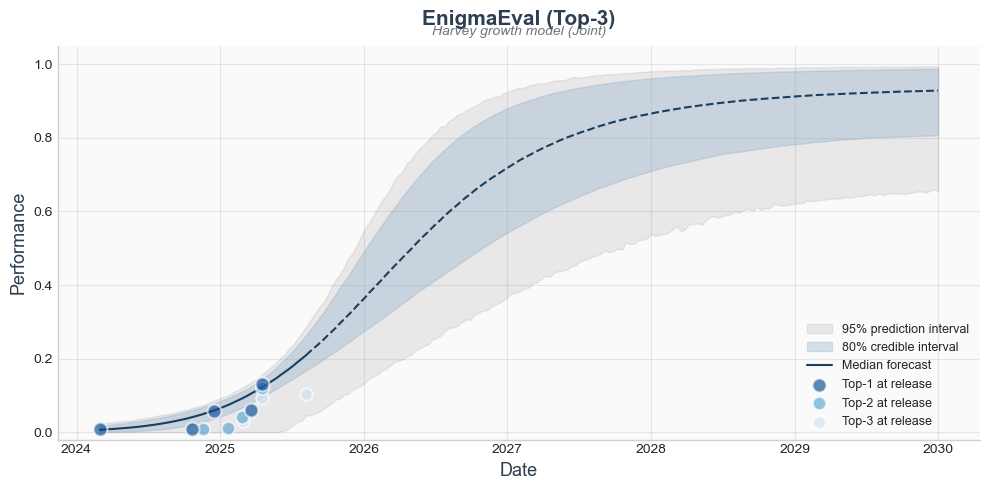

In [5]:
benchmark = "EnigmaEval"

plot_single_benchmark(
    task_name=benchmark,
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3,
    ci_level=80,
    show_prediction_interval=True,
    save_path=f"Images/beautiful_{benchmark}.png"
)

Saved plot to: Images/beautiful_comparison.png


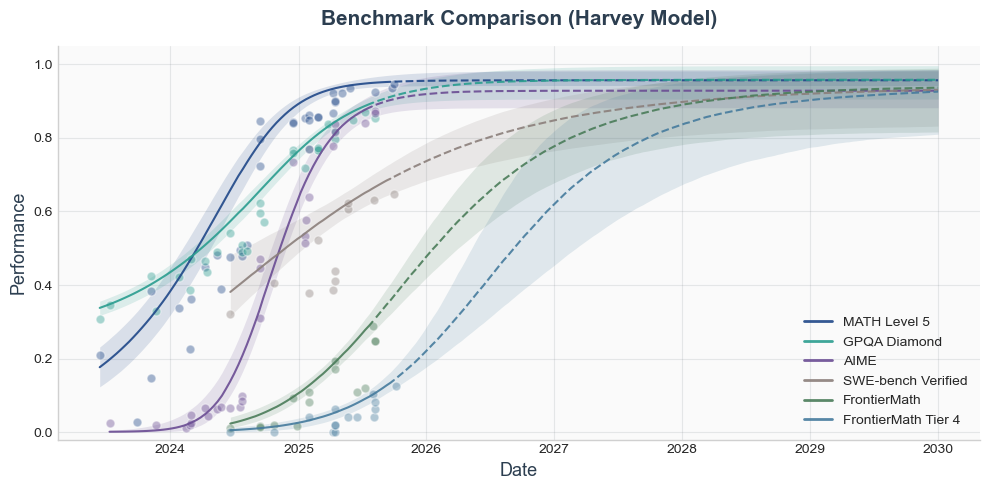

In [6]:
plot_benchmark_comparison(
    task_names=INTERNAL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    ci_level=80,
    save_path="Images/beautiful_comparison.png",
    figsize=(10, 5)
)

Saved plot to: Images/beautiful_grid.png


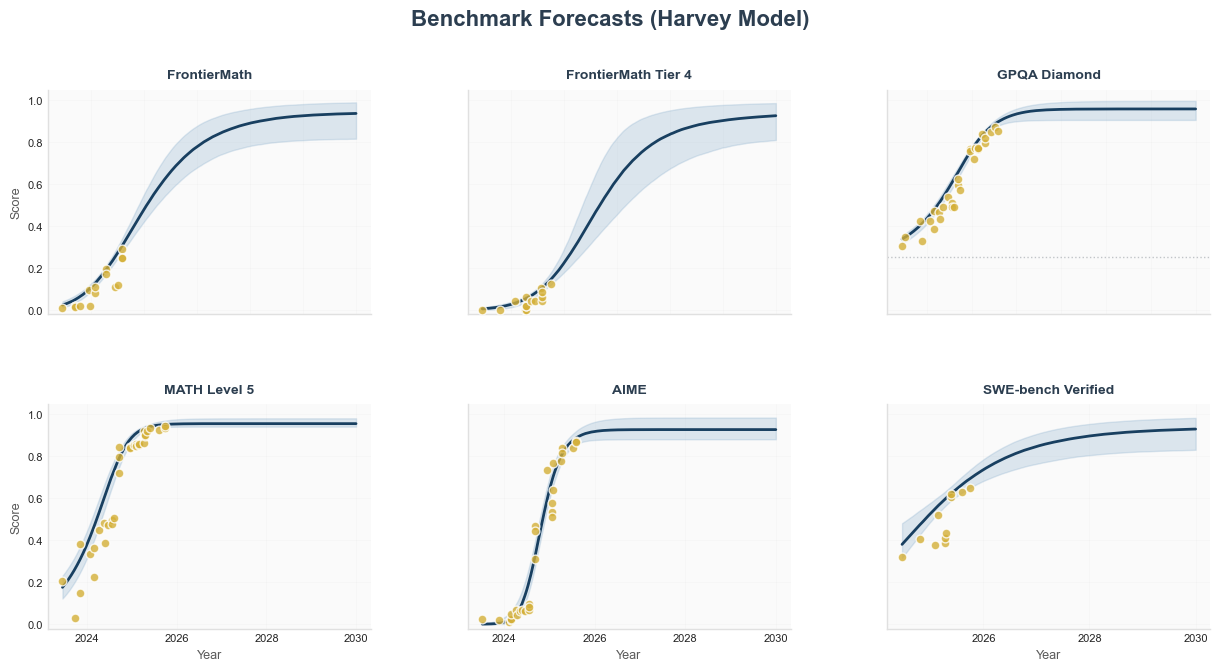

In [7]:
plot_benchmark_grid(
    task_names=INTERNAL_BENCHMARKS,
    forecast_type="harvey_joint_hyperparameters_all",
    ncols=3,
    subplot_size=(5, 3.5),
    save_path="Images/beautiful_grid.png"
)

## Plot by categories (partition by tiers + capabilities)


GENERATING CATEGORY PLOTS


----------------------------------------------------------------------
Category: Progrès vers l'AGI (Tier 3)
Benchmarks: 2
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier3_core_agi.png


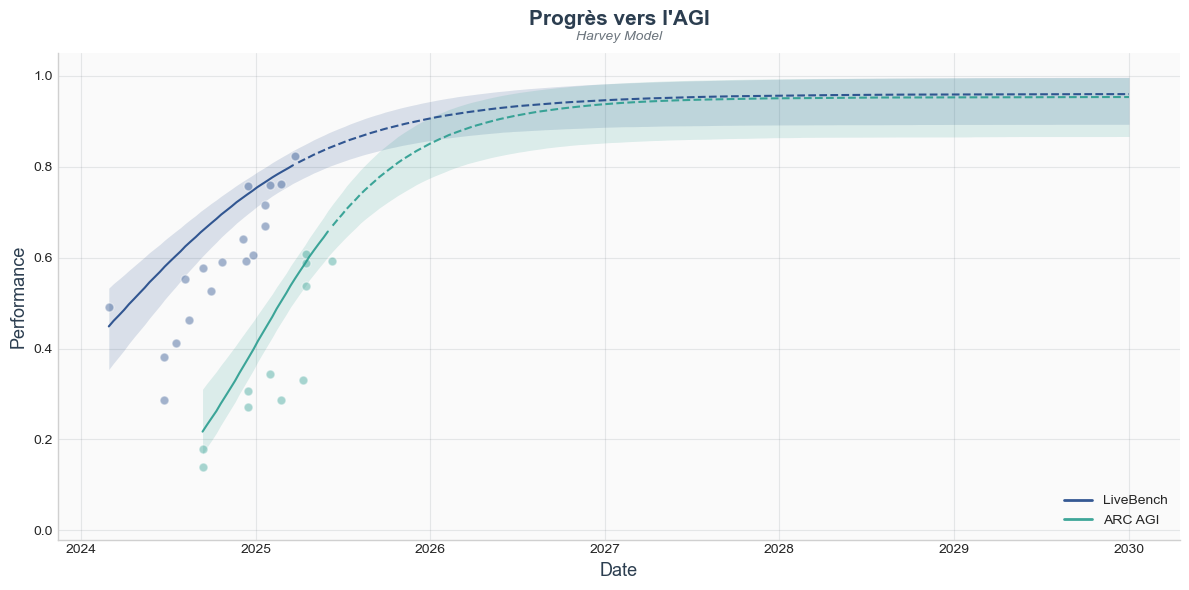

  ✅ Saved: Images/Categories/tier3_core_agi.png

----------------------------------------------------------------------
Category: Raisonnement Mathématique de Haut Niveau (Tier 3)
Benchmarks: 4
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier3_math.png


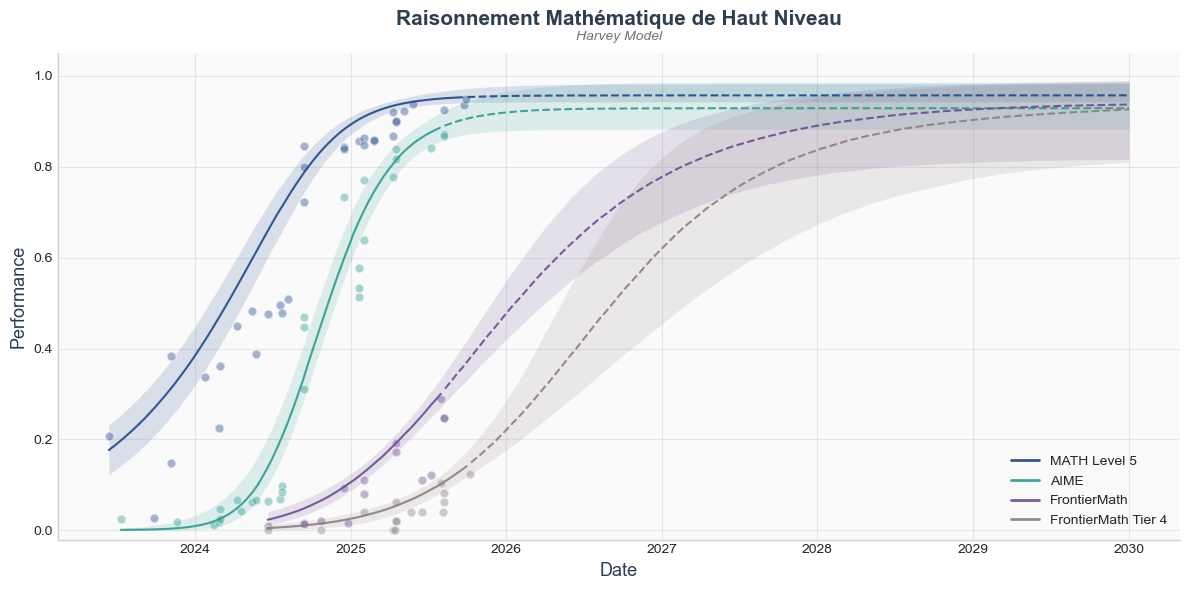

  ✅ Saved: Images/Categories/tier3_math.png

----------------------------------------------------------------------
Category: Développement Logiciel Autonome (Tier 3)
Benchmarks: 4
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier3_engineering.png


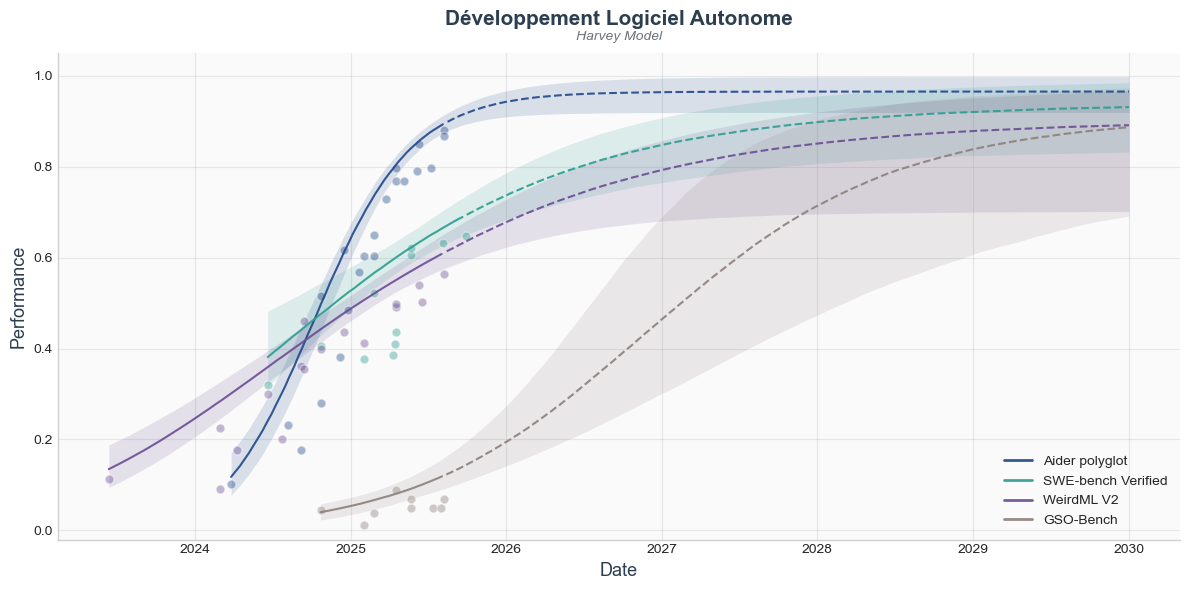

  ✅ Saved: Images/Categories/tier3_engineering.png

----------------------------------------------------------------------
Category: Utilisation Agentique de l'Ordinateur (Tier 3)
Benchmarks: 6
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier3_computer_use.png


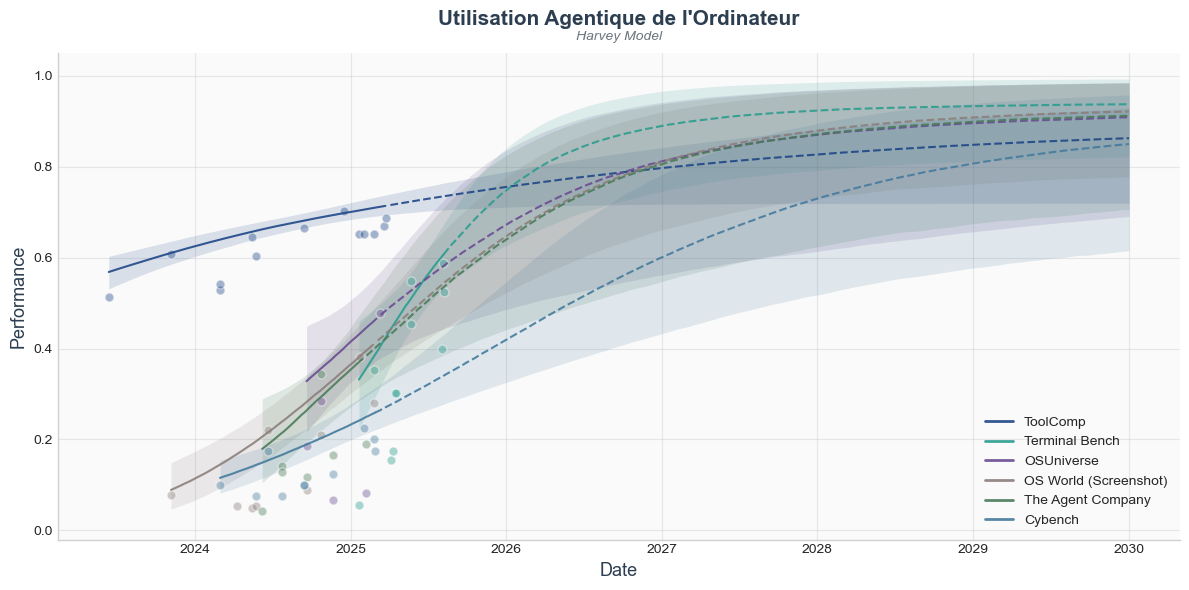

  ✅ Saved: Images/Categories/tier3_computer_use.png

----------------------------------------------------------------------
Category: Questions de Science et Mathématiques (Tier 2)
Benchmarks: 5
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier2_science_math.png


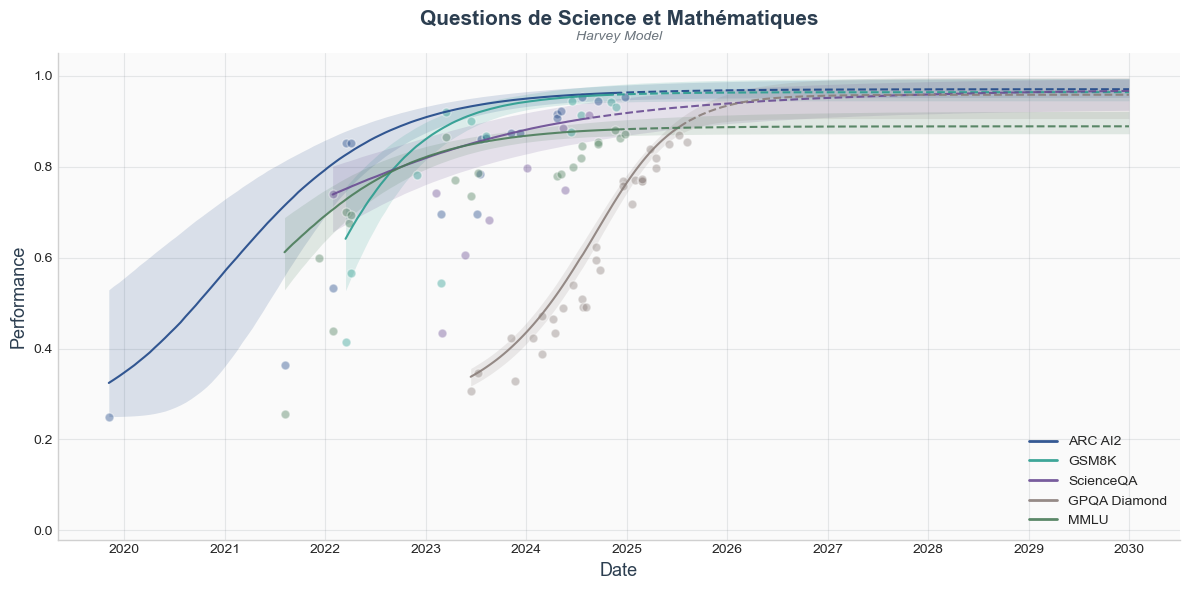

  ✅ Saved: Images/Categories/tier2_science_math.png

----------------------------------------------------------------------
Category: Raisonnement Général (Tier 2)
Benchmarks: 5
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier2_reasoning.png


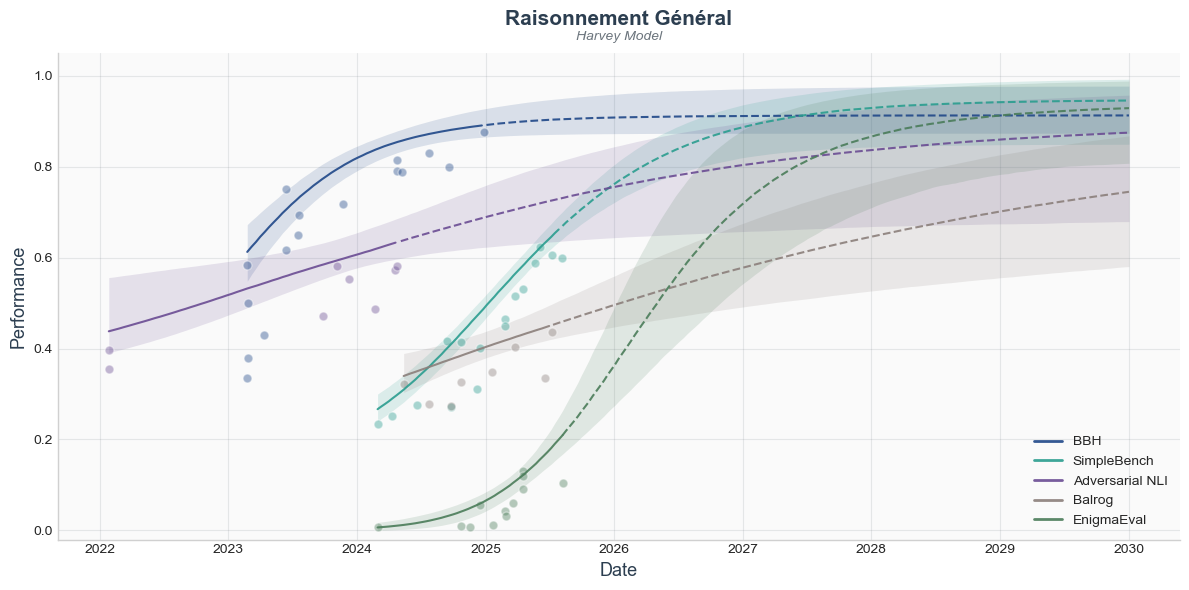

  ✅ Saved: Images/Categories/tier2_reasoning.png

----------------------------------------------------------------------
Category: Compréhension Multimodale (Tier 2)
Benchmarks: 4
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier2_multimodal.png


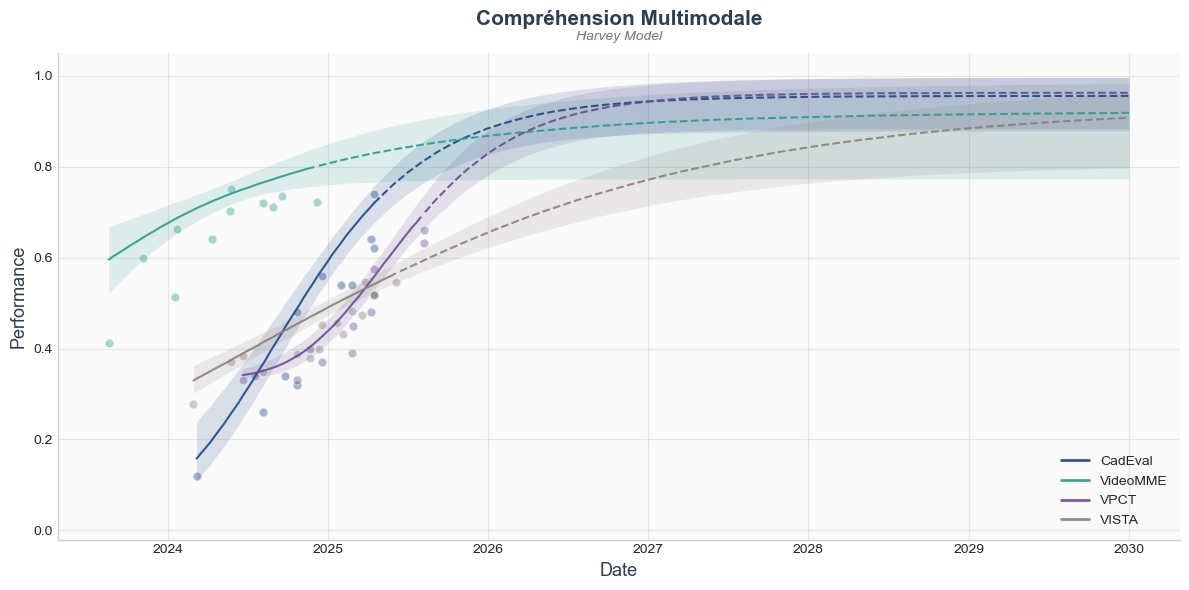

  ✅ Saved: Images/Categories/tier2_multimodal.png

----------------------------------------------------------------------
Category: Langage et Rédaction Avancés (Tier 2)
Benchmarks: 3
----------------------------------------------------------------------
Saved plot to: Images/Categories/tier2_language.png


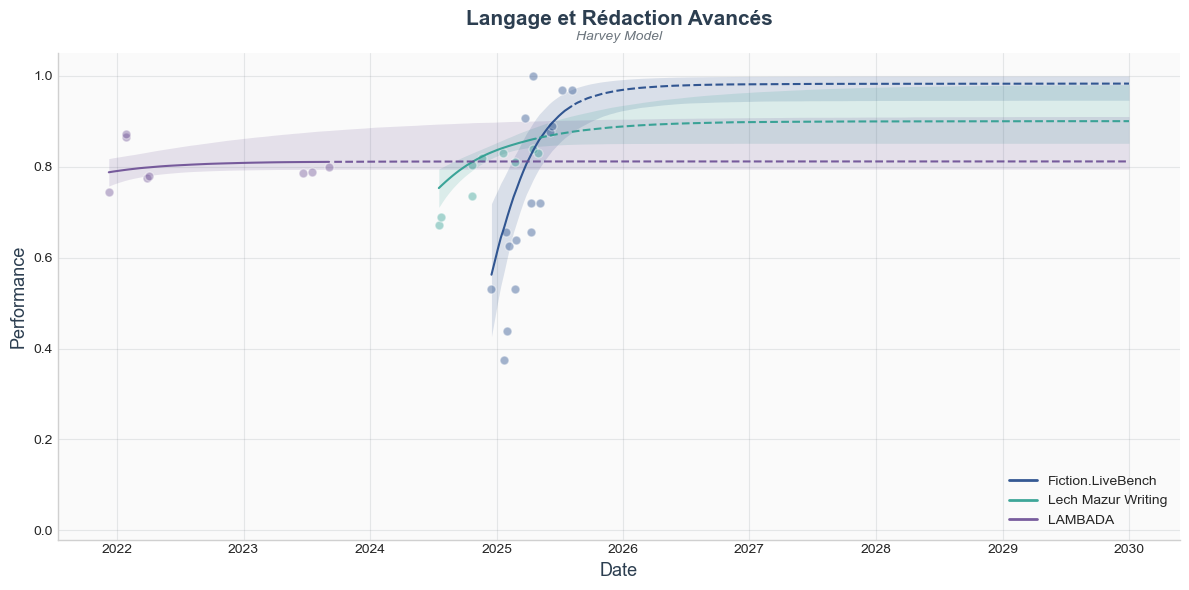

  ✅ Saved: Images/Categories/tier2_language.png

----------------------------------------------------------------------
Category: Questions de Sens Commun (Tier 1)
Benchmarks: 7
----------------------------------------------------------------------
Error loading CommonSenseQA 2: Benchmark 'CommonSenseQA 2' has only 2 datapoints, but minimum required is 5
Saved plot to: Images/Categories/tier1_commonsense.png


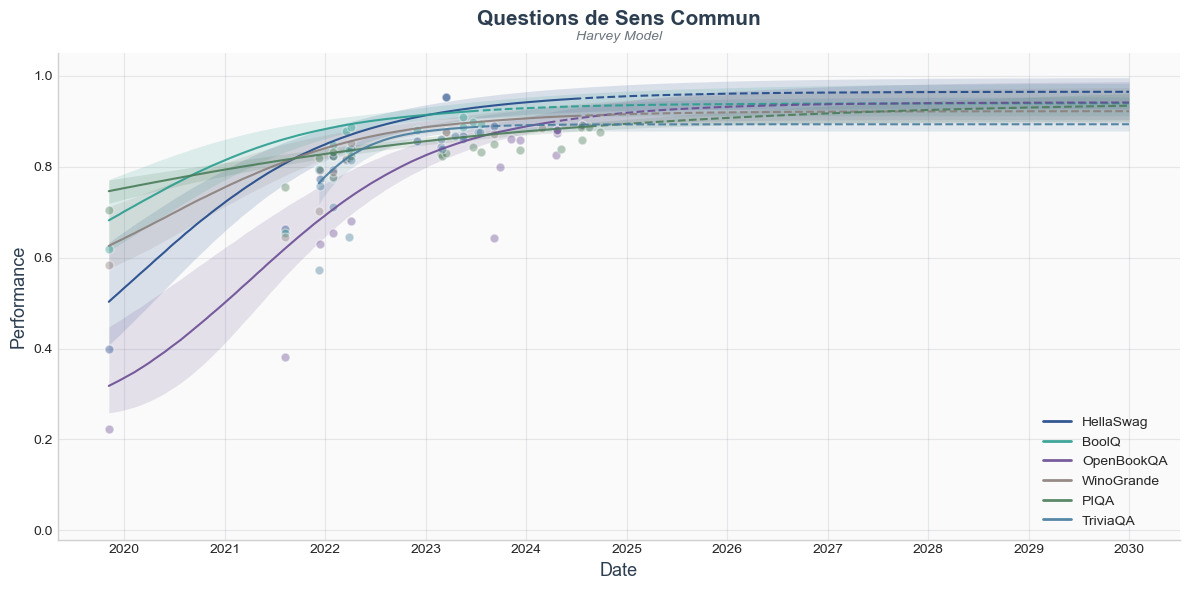

  ✅ Saved: Images/Categories/tier1_commonsense.png

SUMMARY
  ✅ Successful: 9/9
  ❌ Failed: 0/9
  📁 Output directory: Images/Categories



In [8]:
# ============================================================================
# PLOT ALL TIER/CAPABILITY CATEGORIES
# ============================================================================

# Define all categories with their metadata
CATEGORIES = {
    'tier3_core_agi': {
        'benchmarks': TIER3_CORE_AGI_PROGRESS,
        'name': 'Progrès vers l\'AGI',
        'tier': 3
    },
    'tier3_math': {
        'benchmarks': TIER3_HIGH_END_MATH_REASONING,
        'name': 'Raisonnement Mathématique de Haut Niveau',
        'tier': 3
    },
    'tier3_engineering': {
        'benchmarks': TIER3_AUTONOMOUS_SWE,
        'name': 'Développement Logiciel Autonome',
        'tier': 3
    },
    'tier3_computer_use': {
        'benchmarks': TIER3_AGENTIC_COMPUTER_USE,
        'name': 'Utilisation Agentique de l\'Ordinateur',
        'tier': 3
    },
    'tier2_science_math': {
        'benchmarks': TIER2_SCIENCE_AND_MATH_QUESTIONS,
        'name': 'Questions de Science et Mathématiques',
        'tier': 2
    },
    'tier2_reasoning': {
        'benchmarks': TIER2_GENERAL_REASONING,
        'name': 'Raisonnement Général',
        'tier': 2
    },
    'tier2_multimodal': {
        'benchmarks': TIER2_MULTIMODAL_UNDERSTANDING,
        'name': 'Compréhension Multimodale',
        'tier': 2
    },
    'tier2_language': {
        'benchmarks': TIER2_ADVANCED_LANGUAGE_AND_WRITING,
        'name': 'Langage et Rédaction Avancés',
        'tier': 2
    },
    'tier1_commonsense': {
        'benchmarks': TIER1_COMMONSENSE_QA,
        'name': 'Questions de Sens Commun',
        'tier': 1
    }
}

def plot_all_categories(forecast_type="harvey_joint_hyperparameters_all", 
                       top_n=3, 
                       ci_level=80,
                       output_dir="Images/Categories"):
    """
    Generate and save plots for all tier/capability categories.
    
    Args:
        forecast_type: type of forecast model
        top_n: number of top models
        ci_level: credible interval level
        output_dir: directory to save plots
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"GENERATING CATEGORY PLOTS")
    print(f"{'='*70}\n")
    
    # Track statistics
    successful = 0
    failed = 0
    
    for category_id, category_info in CATEGORIES.items():
        benchmarks = category_info['benchmarks']
        name = category_info['name']
        tier = category_info['tier']
        
        print(f"\n{'-'*70}")
        print(f"Category: {name} (Tier {tier})")
        print(f"Benchmarks: {len(benchmarks)}")
        print(f"{'-'*70}")
        
        # Skip if no benchmarks
        if not benchmarks:
            print(f"  ⚠️  No benchmarks in category, skipping...")
            continue
        
        try:
            # Generate filename
            safe_name = category_id.replace(' ', '_').replace('&', 'and')
            save_path = os.path.join(output_dir, f"{safe_name}.png")
            
            # Plot comparison with category metadata
            plot_benchmark_comparison(
                task_names=benchmarks,
                forecast_type=forecast_type,
                top_n=top_n,
                ci_level=ci_level,
                figsize=(12, 6),
                save_path=save_path,
                category_name=name  # Pass category name
            )
            
            print(f"  ✅ Saved: {save_path}")
            successful += 1
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            failed += 1
    
    # Summary
    print(f"\n{'='*70}")
    print(f"SUMMARY")
    print(f"{'='*70}")
    print(f"  ✅ Successful: {successful}/{len(CATEGORIES)}")
    print(f"  ❌ Failed: {failed}/{len(CATEGORIES)}")
    print(f"  📁 Output directory: {output_dir}")
    print(f"{'='*70}\n")

# Run the plotting function
plot_all_categories(
    forecast_type="harvey_joint_hyperparameters_all",
    top_n=3,
    ci_level=80,
    output_dir="Images/Categories"
)